# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [10]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import scipy.stats as st
import json
from scipy.stats import linregress

from scipy import stats



# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [11]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random Lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each Lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(len(cities))




640


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [12]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "metric"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="

In [13]:
# Creating Lists for each important value we are trying to store from the json response we receive back from the API once it has received the location we are interested in.

Location = []
Lat = []
Long = []
Temp = []
MaxTemp = []
MinTemp = []
Humidity = []
Clouds = []
Wind = []
Country = []
Datetime = []
# For all the locations in our generated list, irritate through the locations, sending it to the API and when received back, TRY to store the values we are interested in and print in terminal to inform the user it was successful, and if the location isn't available through the API print out a message to inform the user.

for city in cities:
    response = requests.get(query_url + city).json()
    try: 
        Lat.append(response['coord']['lat'])                    # The response for the Lat and Long is placed first and second in the TRY logic as these two variables are to be tested first. if they are not available in the response we dont want to store the City in our new list but rather we want the logic to exit the condition and iterate to the next City in our list.
        Long.append(response['coord']['lon'])
        Location.append(city)
        Temp.append(response['main']['temp'])
        MaxTemp.append(response['main']['temp_max'])
        MinTemp.append(response['main']['temp_min'])
        Humidity.append(response['main']['humidity'])
        Clouds.append(response['clouds']['all'])
        Wind.append(response['wind']['speed'])
        Country.append(response['sys']['country'])
        Datetime.append(response['dt'])
        print(f'Location number: {len(Country)} the city of: {city} has been added to the list of possible travel destinations')
    except KeyError:
        print(f"The city of: {city} is unavailable")


Location number: 1 the city of: bereda has been added to the list of possible travel destinations
Location number: 2 the city of: arraial do cabo has been added to the list of possible travel destinations
Location number: 3 the city of: dingle has been added to the list of possible travel destinations
Location number: 4 the city of: sioux lookout has been added to the list of possible travel destinations
Location number: 5 the city of: constitucion has been added to the list of possible travel destinations
Location number: 6 the city of: snezhnogorsk has been added to the list of possible travel destinations
Location number: 7 the city of: vytegra has been added to the list of possible travel destinations
Location number: 8 the city of: seoul has been added to the list of possible travel destinations
Location number: 9 the city of: hodkovice nad mohelkou has been added to the list of possible travel destinations
Location number: 10 the city of: hami has been added to the list of possib

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [14]:
# Storing the list of values we stored into a main dataframe (weather_data)

weather_dict = {
    "City": Location,
    "Lat": Lat,
    "Long": Long,
    "Temp": Temp,
    "Max Temp": MaxTemp,
    "Min Temp": MinTemp,
    "Humidity" : Humidity,
    "Clouds": Clouds,
    "Wind" : Wind,
    "Country" : Country,
    "Datetime" : Datetime
}
weather_data = pd.DataFrame(weather_dict)
weather_data.head()

# Output the dataframe complied into a CSV that will be used for the VacationPy 
weather_data.to_csv('City_Data.csv', index=False)

In [15]:
# inspecting the weather_data dataframe
weather_data.head()

,City,Lat,Long,Temp,Max Temp,Min Temp,Humidity,Clouds,Wind,Country,Datetime
0,bereda,43.2686,-7.5406,30.88,31.90,30.88,59,24,2.44,ES,1660234341
1,arraial do cabo,-22.9661,-42.0278,21.92,21.92,21.92,68,40,11.32,BR,1660234342
2,dingle,10.9995,122.6711,25.03,25.03,25.03,87,89,0.41,PH,1660234342
3,sioux lookout,50.1001,-91.9170,20.89,20.89,20.89,31,0,0.90,CA,1660234342
4,constitucion,-35.3333,-72.4167,13.12,13.12,13.12,61,0,2.35,CL,1660234342


In [16]:
# checking dataset for even rows amongst all columns 
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      595 non-null    object 
 1   Lat       595 non-null    float64
 2   Long      595 non-null    float64
 3   Temp      595 non-null    float64
 4   Max Temp  595 non-null    float64
 5   Min Temp  595 non-null    float64
 6   Humidity  595 non-null    int64  
 7   Clouds    595 non-null    int64  
 8   Wind      595 non-null    float64
 9   Country   595 non-null    object 
 10  Datetime  595 non-null    int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 51.3+ KB


## Inspect the data and remove the cities where the Humidity > 100%.
----
Skip this step if there are no cities that have Humidity > 100%. 

In [17]:
#  Test to see if any locations have a humidity above 100s
(weather_data.loc[weather_data['Humidity'] > 100, :]).info()   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      0 non-null      object 
 1   Lat       0 non-null      float64
 2   Long      0 non-null      float64
 3   Temp      0 non-null      float64
 4   Max Temp  0 non-null      float64
 5   Min Temp  0 non-null      float64
 6   Humidity  0 non-null      int64  
 7   Clouds    0 non-null      int64  
 8   Wind      0 non-null      float64
 9   Country   0 non-null      object 
 10  Datetime  0 non-null      int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 0.0+ bytes


In [18]:
# Drop any locations that had a humidity over 100
# As the locations are generated randomly, this step is included as a fail safe 
weather_data = weather_data.loc[weather_data['Humidity'] <= 100, :]
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595 entries, 0 to 594
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      595 non-null    object 
 1   Lat       595 non-null    float64
 2   Long      595 non-null    float64
 3   Temp      595 non-null    float64
 4   Max Temp  595 non-null    float64
 5   Min Temp  595 non-null    float64
 6   Humidity  595 non-null    int64  
 7   Clouds    595 non-null    int64  
 8   Wind      595 non-null    float64
 9   Country   595 non-null    object 
 10  Datetime  595 non-null    int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 55.8+ KB


## Plotting the Data
* Use proper labelling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

In [35]:
# Set graph size for all graphs
plt.rcParams["figure.figsize"] = (15,15)

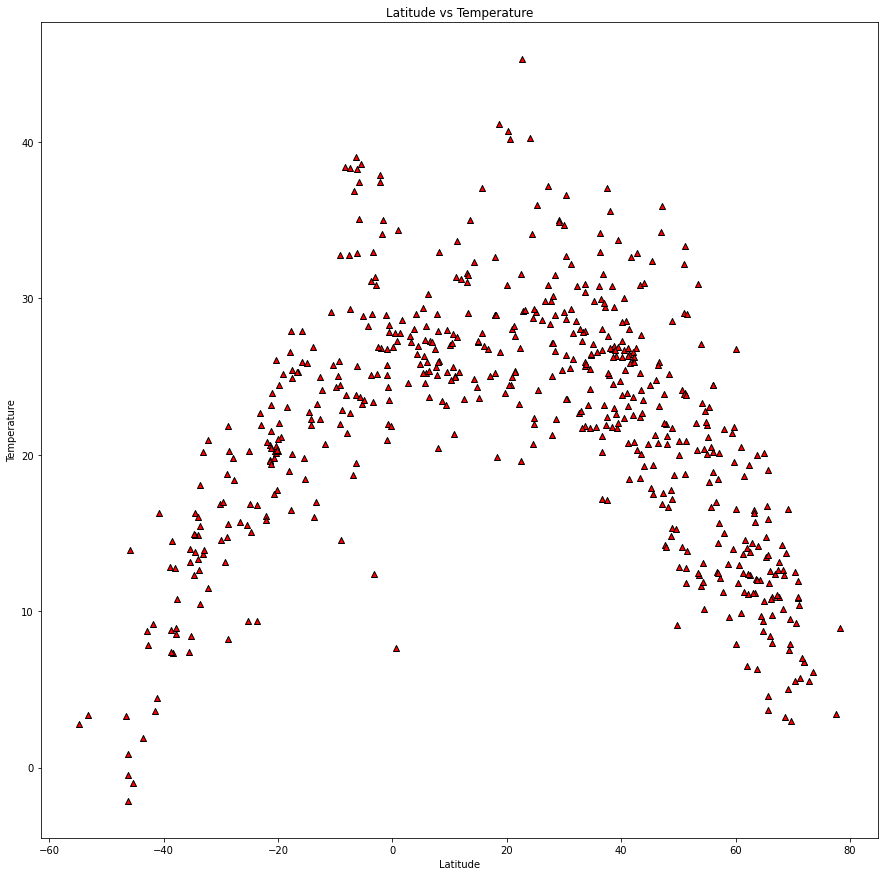

<Figure size 1080x1080 with 0 Axes>

In [36]:
# We are plotting latitude and temperature. We can observe that the temperature near the equator (Lat = 0) is warmer and it becomes colder as you move away from the centre.

x = weather_data['Lat']
y = weather_data['Temp']

plt.scatter(x,y,  marker="^", facecolors="red", edgecolors="black")
plt.title('Latitude vs Temperature')
plt.xlabel('Latitude')
plt.ylabel('Temperature')
plt.show()
plt.savefig('Latitude vs Temperature.png')

## Latitude vs. Humidity Plot

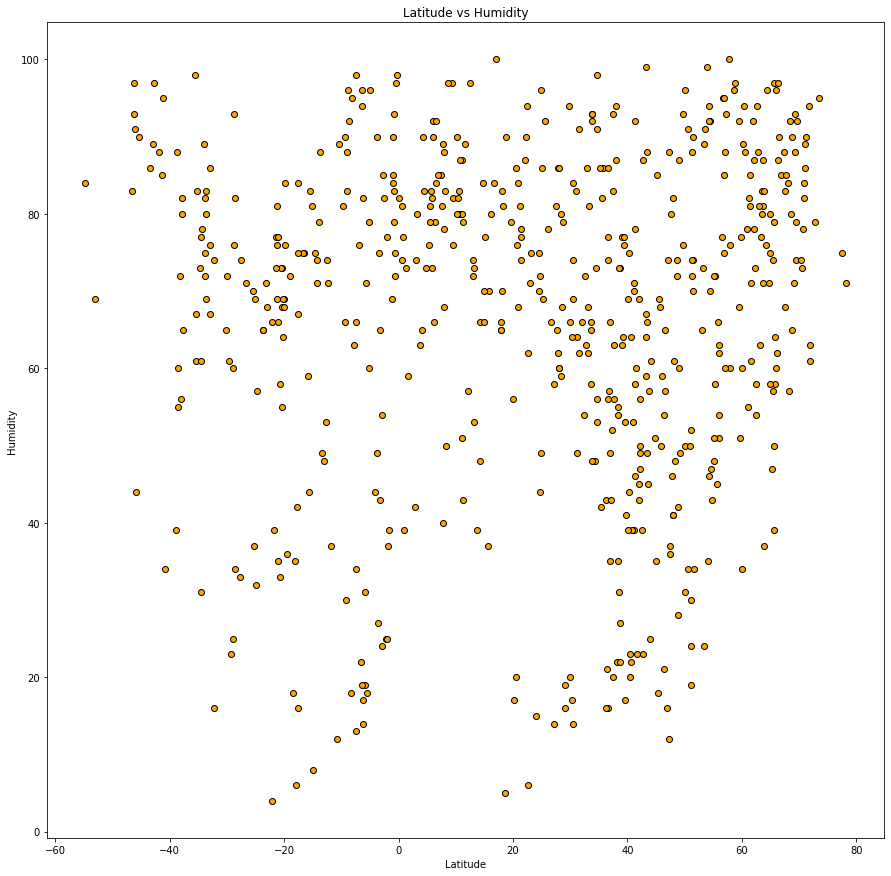

<Figure size 1080x1080 with 0 Axes>

In [37]:
# We are plotting latitude and humidity. Visually it doesn't appear to have a relationship - we can attribute that to humidity doesn't depend on latitude, but rather other factors like weather patterns. 
x = weather_data["Lat"]
y = weather_data['Humidity']


plt.scatter(x,y,  marker="o", facecolors="orange", edgecolors="black")
plt.title('Latitude vs Humidity')
plt.xlabel('Latitude')
plt.ylabel('Humidity')
plt.show()
plt.savefig('Latitude vs Humidity.png')

## Latitude vs. Cloudiness Plot

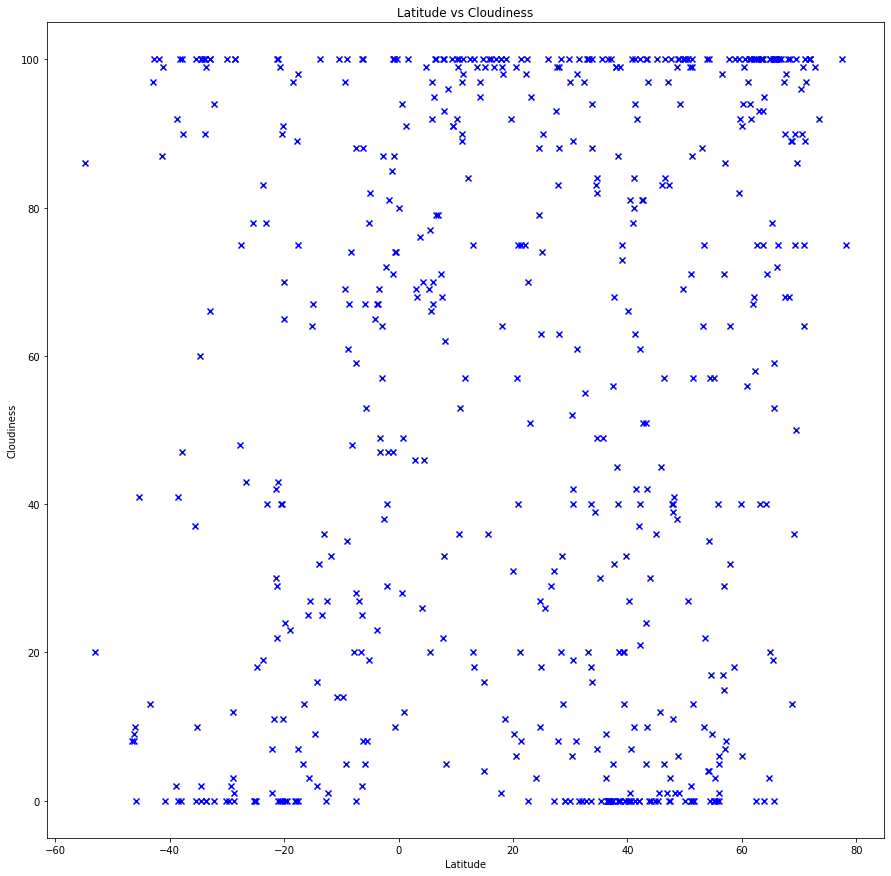

<Figure size 1080x1080 with 0 Axes>

In [38]:
# We are plotting latitude vs cloud coverage as a % - from the graph we can see cloud coverage doesn't show any relationship based on latitude of the location.

x = weather_data["Lat"]
y = weather_data['Clouds']


plt.scatter(x,y,  marker="x", facecolors="blue")
plt.title('Latitude vs Cloudiness')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
plt.show()
plt.savefig('Latitude vs Cloudiness.png')

## Latitude vs. Wind Speed Plot

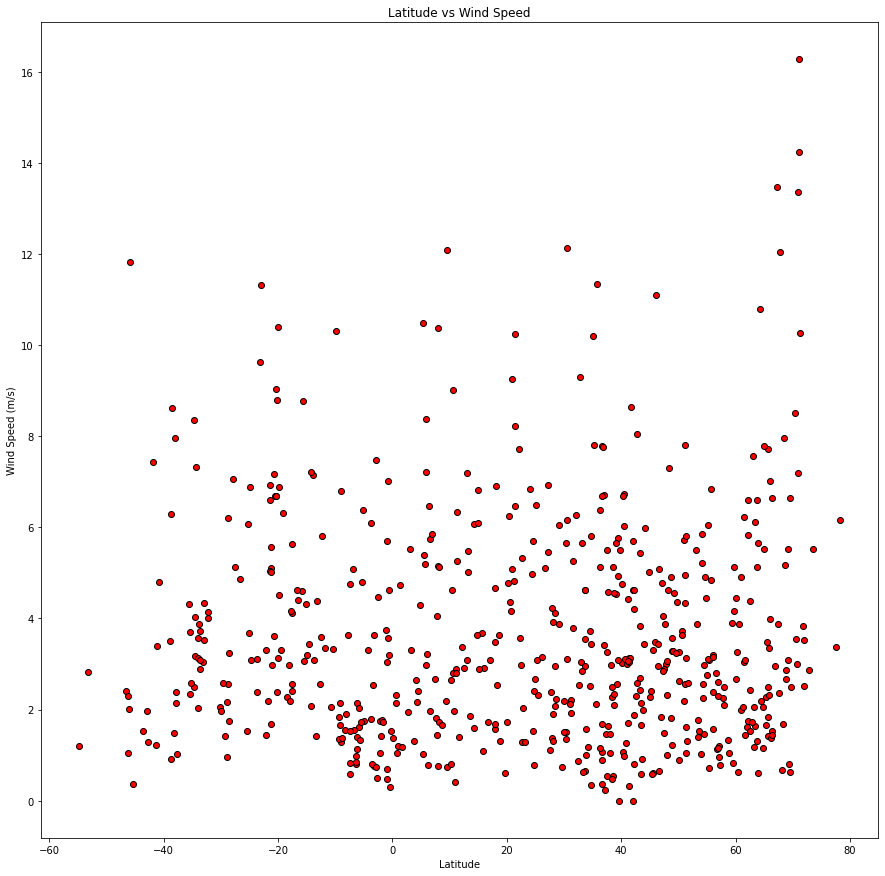

<Figure size 1080x1080 with 0 Axes>

In [39]:
# We are plotting latitude and wind speed. We aren't able to concretely establish a relationship between wind speed and latitude. This is due to wind being a part product of high and low pressure fronts which move independent of latitude.

x = weather_data["Lat"]
y = weather_data['Wind']


plt.scatter(x,y,  marker="o", facecolors="red", edgecolors="black")
plt.title('Latitude vs Wind Speed')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (m/s)')
plt.show()
plt.savefig('Latitude vs Wind Speed.png')

## Linear Regression

###  Max Temp vs. Latitude Linear Regression

In [24]:
# We are going to separate cities by their hemisphere:

northern_hem = weather_data.loc[weather_data['Lat'] >= 0,:]
southern_hem = weather_data.loc[weather_data['Lat'] < 0,:]


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

In [25]:
def regression_line (x,y):
    (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x, y)
    regress_values = x * slope + intercept
    return regress_values

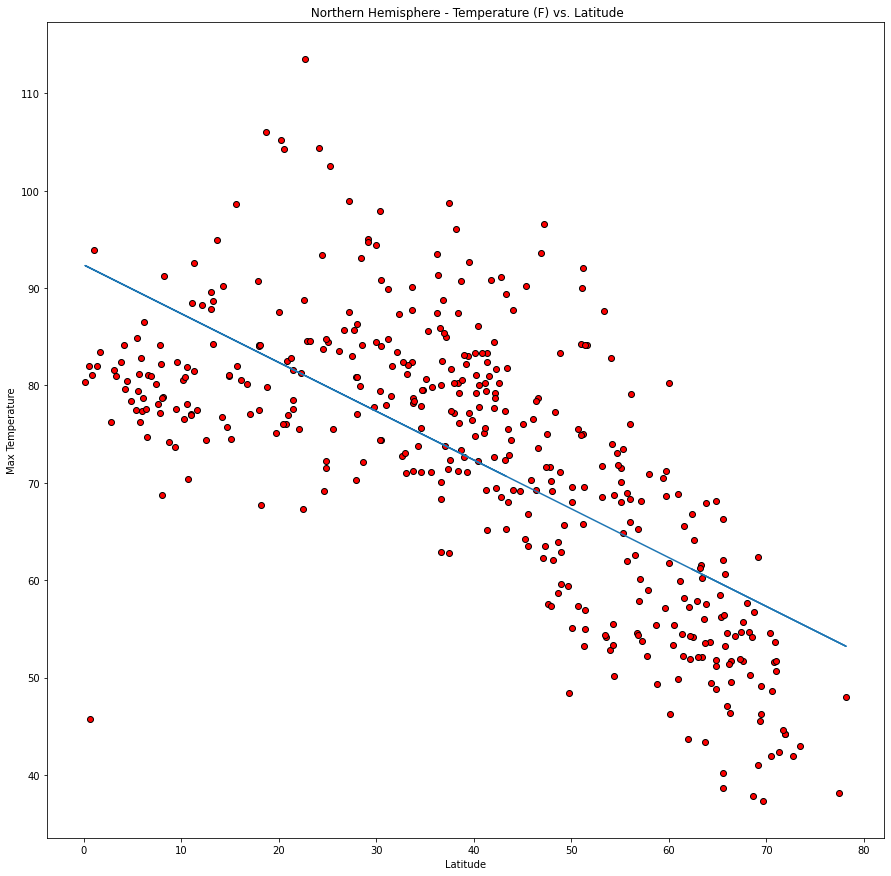

The correlation coefficient between the Max Temp and Latitude (Northern Hemisphere) is -0.7


In [40]:
# Here we are plotting max temperature (Northern Hemisphere) in F and latitude. We can observe a negative correlation which is said to be good to strong as we have a correlation coefficient of -0.7
# covert max temp from C to F
y = [(i*1.8+32) for i in northern_hem['Max Temp']]
x = pd.Series(northern_hem['Lat'])

reg_line = regression_line(x,y)
plt.scatter(x,y,  marker="o", facecolors="red", edgecolors="black")
plt.plot(x,reg_line)
plt.title(' Northern Hemisphere - Temperature (F) vs. Latitude')
plt.xlabel('Latitude')
plt.ylabel('Max Temperature')
plt.savefig('Northern Hemisphere - Max Temperature vs Latitude.png')
plt.show()
print(f"The correlation coefficient between the Max Temp and Latitude (Northern Hemisphere) is {round(st.pearsonr(x,y)[0],2)}")


####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

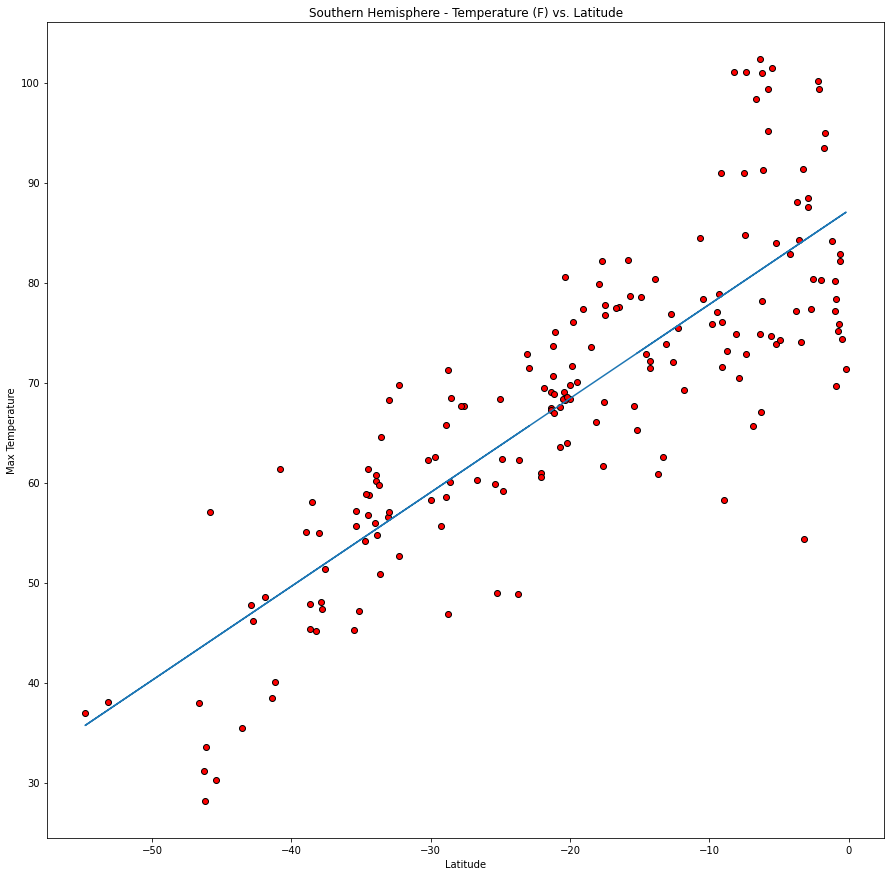

The correlation coefficient between the Max Temp and Latitude (Southern Hemisphere) is 0.83


<Figure size 1080x1080 with 0 Axes>

In [44]:
# Here we are plotting max temperature (Southern Hemisphere) in F and latitude. We can observe a positive correlation which is said to be good to strong as we have a correlation coefficient of 0.83
# covert max temp from C to F
y = [(i*1.8+32) for i in southern_hem['Max Temp']] 
x = pd.Series(southern_hem['Lat'])

reg_line = regression_line(x,y)
plt.scatter(x,y,  marker="o", facecolors="red", edgecolors="black")
plt.plot(x, reg_line)
plt.title('Southern Hemisphere - Temperature (F) vs. Latitude')
plt.xlabel('Latitude')
plt.ylabel('Max Temperature')
plt.show()
plt.savefig('Southern Hemisphere - Max Temperature vs Latitude.png')
print(f"The correlation coefficient between the Max Temp and Latitude (Southern Hemisphere) is {round(st.pearsonr(x,y)[0],2)}")

### Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

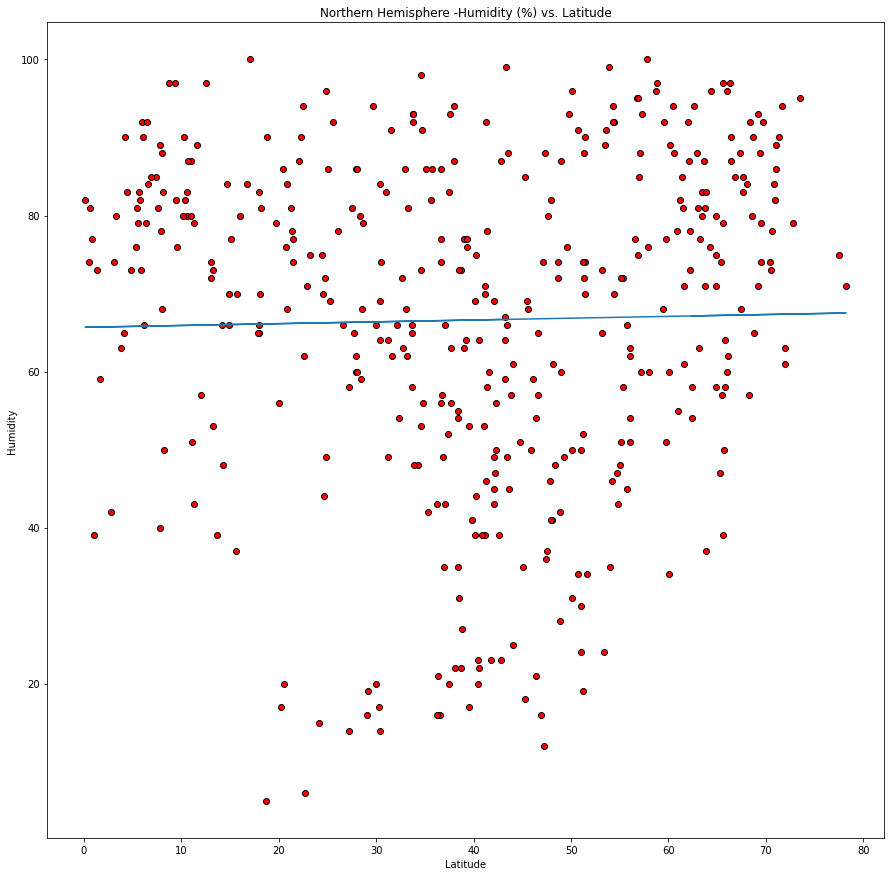

The correlation coefficient between the Humidity and Latitude (Northern Hemisphere) is 0.02


<Figure size 1080x1080 with 0 Axes>

In [42]:
# Here we are plotting humidity (Northern Hemisphere) and latitude, we aren't able to say there is a relationship between the two, which is also supported by the correlation coefficient.

y = northern_hem['Humidity']
x = pd.Series(northern_hem['Lat'])

reg_line = regression_line(x,y)
plt.scatter(x,y,  marker="o", facecolors="red", edgecolors="black")
plt.plot(x, reg_line)
plt.title('Northern Hemisphere -Humidity (%) vs. Latitude')
plt.xlabel('Latitude')
plt.ylabel('Humidity')
plt.show()
plt.savefig('Northern Hemisphere - Humidity vs Latitude.png')
print(f"The correlation coefficient between the Humidity and Latitude (Northern Hemisphere) is {round(st.pearsonr(x,y)[0],2)}")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

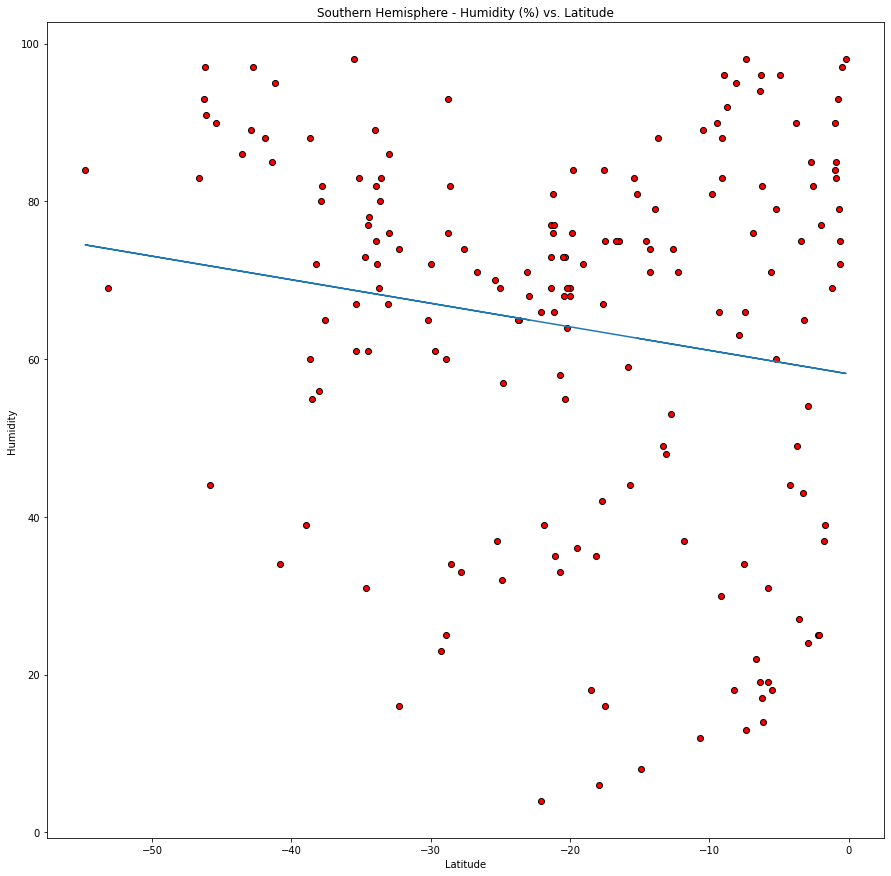

The correlation coefficient between the Humidity and Latitude (Southern Hemisphere) is -0.17


<Figure size 1080x1080 with 0 Axes>

In [43]:
# Here we are plotting humidity (Southern Hemisphere) and latitude, we aren't able to say there is a relationship between the two, which is also supported by the correlation coefficient. (even though we can see a slight negative regression line, its not enough to prove a relationship between the two)

y = southern_hem['Humidity']
x = pd.Series(southern_hem['Lat'])

reg_line = regression_line(x,y)
plt.scatter(x,y,  marker="o", facecolors="red", edgecolors="black")
plt.plot(x, reg_line)
plt.title('Southern Hemisphere - Humidity (%) vs. Latitude')
plt.xlabel('Latitude')
plt.ylabel('Humidity')
plt.show()
plt.savefig('Souther Hemisphere - Humidity vs Latitude.png')
print(f"The correlation coefficient between the Humidity and Latitude (Southern Hemisphere) is {round(st.pearsonr(x,y)[0],2)}")

### Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

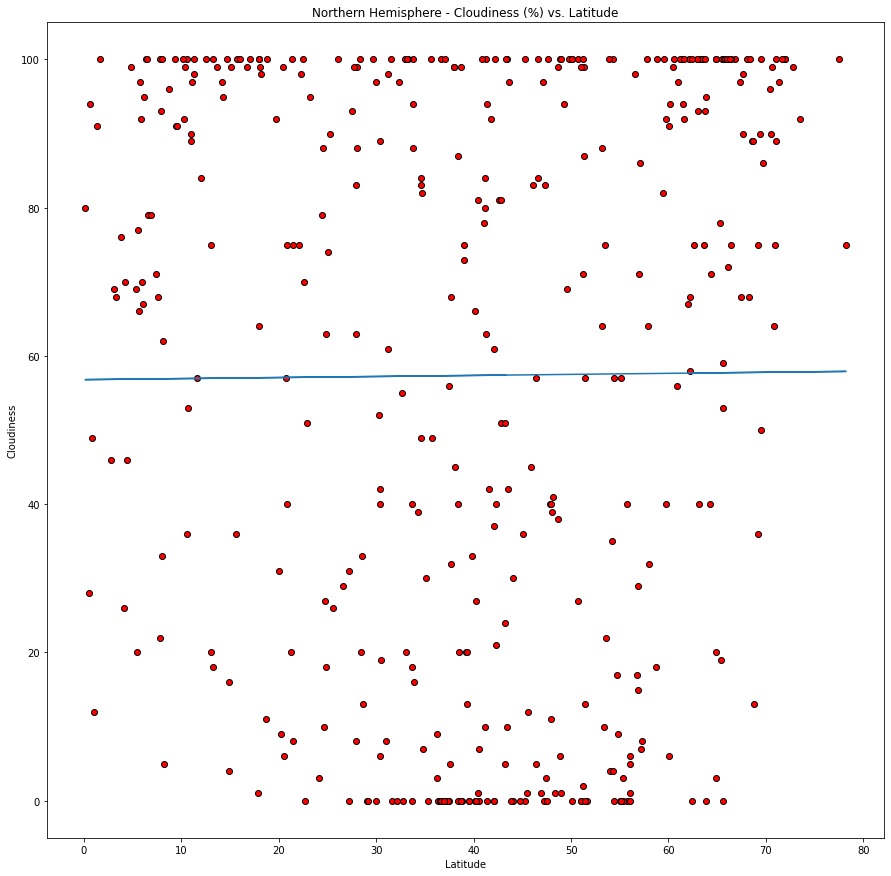

The correlation coefficient between the Cloudiness and Latitude (Northern Hemisphere) is 0.01


<Figure size 1080x1080 with 0 Axes>

In [45]:
# Here we are plotting cloudiness (Northern Hemisphere) and latitude, we aren't able to say there is a relationship between the two, which is also supported by the correlation coefficient.

y = northern_hem['Clouds']
x = pd.Series(northern_hem['Lat'])


reg_line = regression_line(x,y)
plt.scatter(x,y,  marker="o", facecolors="red", edgecolors="black")
plt.plot(x,reg_line)
plt.title('Northern Hemisphere - Cloudiness (%) vs. Latitude')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
plt.show()
plt.savefig('Northern Hemisphere - Cloudiness vs Latitude.png')
print(f"The correlation coefficient between the Cloudiness and Latitude (Northern Hemisphere) is {round(st.pearsonr(x,y)[0],2)}")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

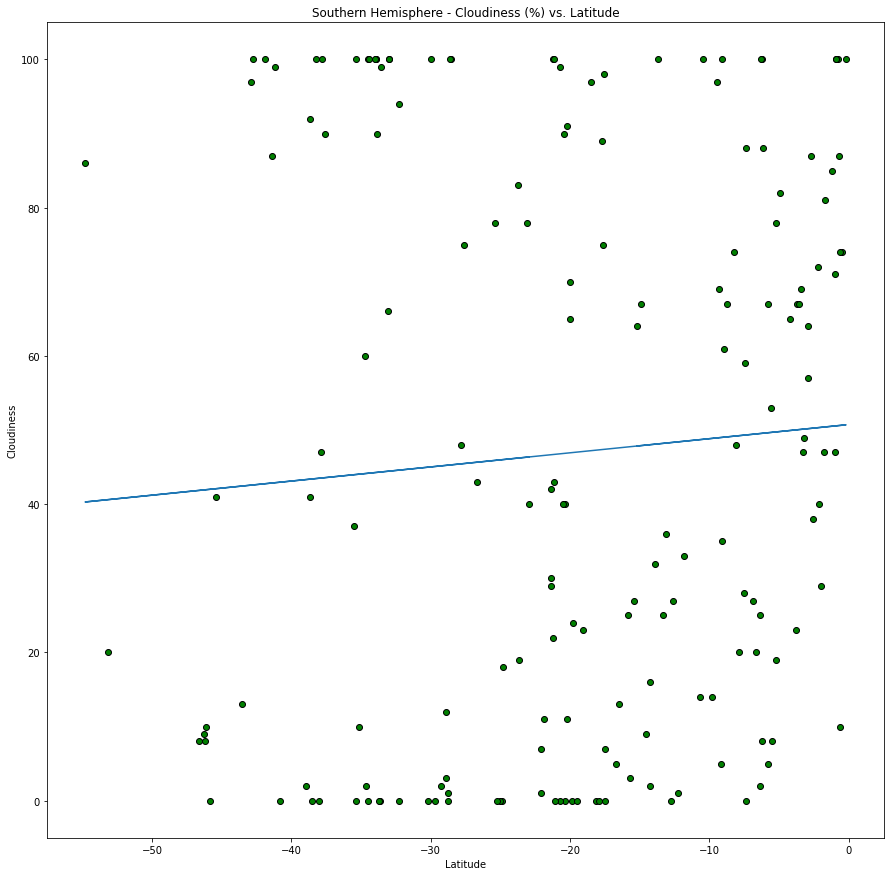

The correlation coefficient between the Cloudiness and Latitude (Southern Hemisphere) is 0.07


<Figure size 1080x1080 with 0 Axes>

In [46]:
# Here we are plotting cloudiness (Southern Hemisphere) and latitude, we aren't able to say there is a relationship between the two, which is also supported by the correlation coefficient.

y = southern_hem['Clouds']
x = pd.Series(southern_hem['Lat'])

reg_line = regression_line(x,y)
plt.scatter(x,y,  marker="o", facecolors="green", edgecolors="black")
plt.plot(x, reg_line)
plt.title('Southern Hemisphere - Cloudiness (%) vs. Latitude')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
plt.show()
plt.savefig('Southern Hemisphere - Cloudiness vs Latitude.png')
print(f"The correlation coefficient between the Cloudiness and Latitude (Southern Hemisphere) is {round(st.pearsonr(x,y)[0],2)}")

### Wind Speed (m/s) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

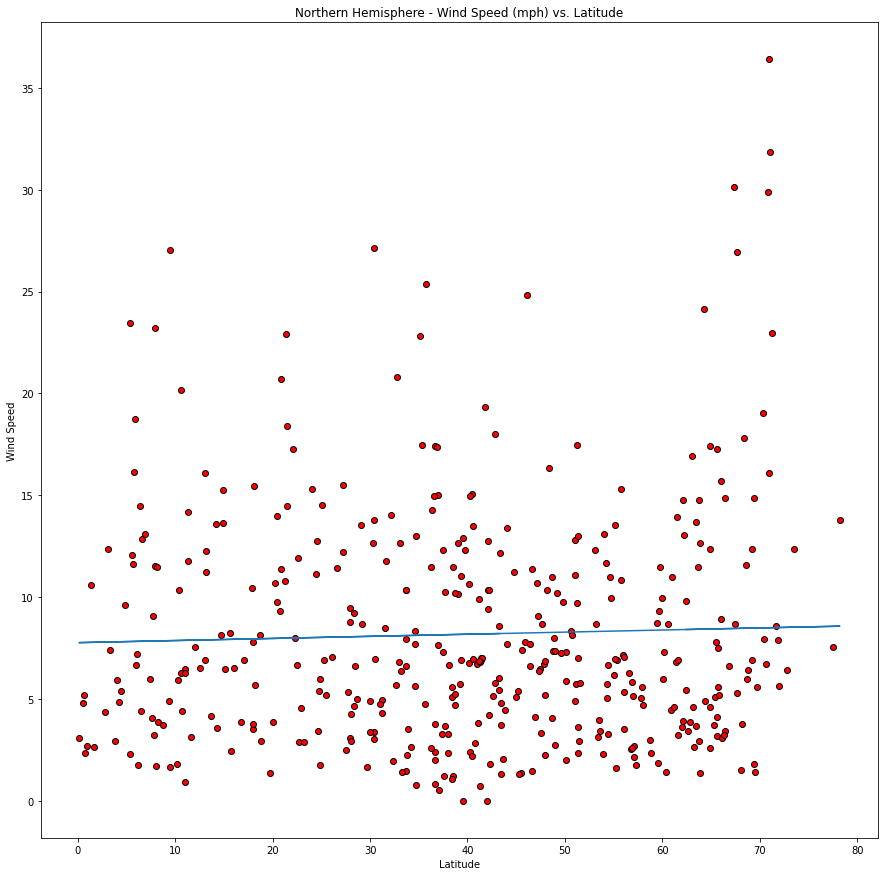

The correlation coefficient between the Cloudiness and Latitude (Northern Hemisphere) is 0.04


<Figure size 1080x1080 with 0 Axes>

In [47]:
# Here we are plotting Wind Speed (Northern Hemisphere) and latitude, we aren't able to say there is a relationship between the two, which is also supported by the correlation coefficient.
# Convert m/s to mph
y = [i*2.23694 for i in northern_hem['Wind']]
x = pd.Series(northern_hem['Lat'])


reg_line = regression_line(x,y)
plt.scatter(x,y,  marker="o", facecolors="red", edgecolors="black")
plt.plot(x, reg_line)
plt.title('Northern Hemisphere - Wind Speed (mph) vs. Latitude')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed')
plt.show()
plt.savefig('Northern Hemisphere - Wind Speed vs Latitude.png')
print(f"The correlation coefficient between the Cloudiness and Latitude (Northern Hemisphere) is {round(st.pearsonr(x,y)[0],2)}")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

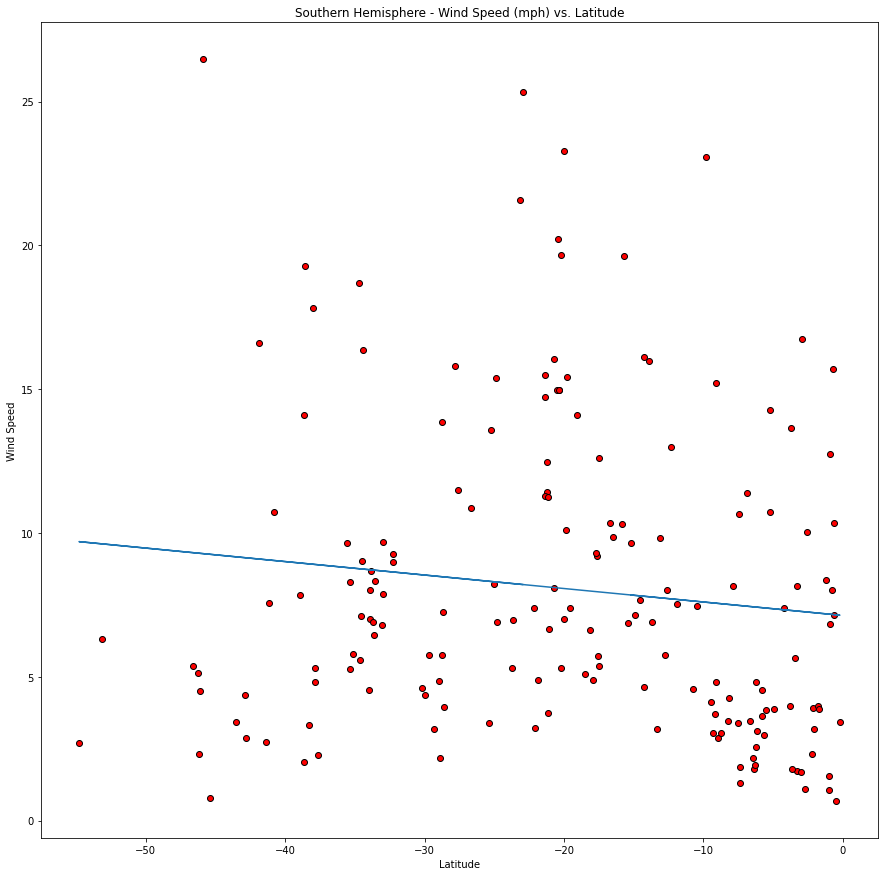

The correlation coefficient between the Cloudiness and Latitude (Northern Hemisphere) is -0.12


<Figure size 1080x1080 with 0 Axes>

In [48]:
# Here we are plotting Wind Speed (souther Hemisphere) and latitude, we aren't able to say there is a relationship between the two, which is also supported by the correlation coefficient.
# Convert m/s to mph
y = [i*2.23694 for i in southern_hem['Wind']]
x = pd.Series(southern_hem['Lat'])


reg_line = regression_line(x,y)
plt.scatter(x,y,  marker="o", facecolors="red", edgecolors="black")
plt.plot(x, reg_line)
plt.title('Southern Hemisphere - Wind Speed (mph) vs. Latitude')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed')
plt.show()
plt.savefig('Southern Hemisphere - Wind Speed vs Latitude.png')
print(f"The correlation coefficient between the Cloudiness and Latitude (Northern Hemisphere) is {round(st.pearsonr(x,y)[0],2)}")